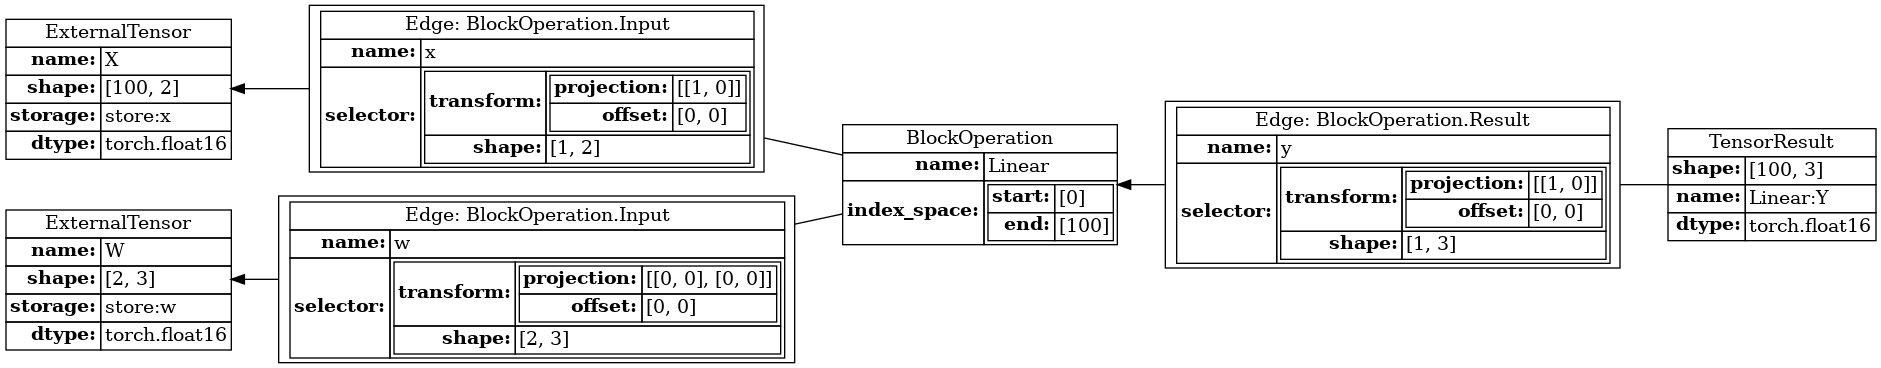

{
  "nodes": {
    "17b6693b-6229-4da9-9aee-3659a6e987fb": {
      "name": "X",
      "shape": [
        100,
        2
      ],
      "storage": "store:x",
      "dtype": "torch.float16",
      "node_id": "17b6693b-6229-4da9-9aee-3659a6e987fb",
      "__type__": "ExternalTensor"
    },
    "0af781a3-a47f-40d7-b8cd-bc05f27c66c2": {
      "name": "W",
      "shape": [
        2,
        3
      ],
      "storage": "store:w",
      "dtype": "torch.float16",
      "node_id": "0af781a3-a47f-40d7-b8cd-bc05f27c66c2",
      "__type__": "ExternalTensor"
    },
    "387da45c-0a39-46bd-aa45-17fde0dd2fa8": {
      "name": "Linear",
      "node_id": "387da45c-0a39-46bd-aa45-17fde0dd2fa8",
      "index_space": {
        "start": [
          0
        ],
        "end": [
          100
        ]
      },
      "__type__": "BlockOperation",
      "__edges__": [
        {
          "name": "x",
          "target_id": "17b6693b-6229-4da9-9aee-3659a6e987fb",
          "source_id": "387da45c-0a39-46bd-aa4

In [2]:
import numpy as np

from tapestry.expression_graph import (
    BlockOperation,
    ExternalTensor,
    TapestryGraph,
    TensorResult,
    TensorValue,
)
from tapestry.jupyter_utils import display_graph
from tapestry.zspace import ZRange, ZRangeMap, ZTransform


def linear(
        x: TensorValue,
        w: TensorValue,
) -> TensorResult:
    graph = x.assert_graph()
    assert w.graph == graph

    assert len(x.shape == 2), x.shape
    batch_size = x.shape[0]

    in_nodes = x.shape[1]
    assert w.shape[0] == in_nodes
    out_nodes = w.shape[1]

    index_space = ZRange([batch_size])

    y_shape = np.array([batch_size, out_nodes])

    op_name = "Linear"

    op = graph.add_node(
        BlockOperation(
            name=op_name,
            index_space=index_space,
        )
    )

    graph.add_node(
        BlockOperation.Input(
            source_id=op.node_id,
            target_id=x.node_id,
            selector=ZRangeMap(
                transform=ZTransform([[1, 0]]),
                shape=[1, in_nodes],
            ),
            name="x",
        )
    )

    graph.add_node(
        BlockOperation.Input(
            source_id=op.node_id,
            target_id=w.node_id,
            selector=ZRangeMap.constant_map(2, shape=w.shape),
            name="w",
        )
    )

    y = graph.add_node(
        TensorResult(
            name=f"{op_name}:Y",
            shape=y_shape,
            dtype="torch.float16",
        )
    )

    graph.add_node(
        BlockOperation.Result(
            source_id=y.node_id,
            target_id=op.node_id,
            selector=ZRangeMap(
                transform=ZTransform([[1, 0]]),
                shape=[1, out_nodes],
            ),
            name="y",
        ),
    )

    return y



g = TapestryGraph()

x = g.add_node(
    ExternalTensor(
        name="X",
        shape=[100, 2],
        dtype="torch.float16",
        storage="store:x",
    )
)

w = g.add_node(
    ExternalTensor(
        name="W",
        shape=[2, 3],
        dtype="torch.float16",
        storage="store:w",
    )
)

y = linear(x, w)

g.validate()

display_graph(g)

print(g.pretty())